# **Linear Algebra** 





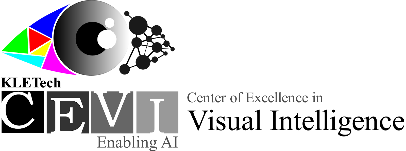

 
06/07/2022 <br>
code by Tejas Anvekar <br>
Speaker Tejas Anvekar

## Solving Systems using Elimination


In this section we discuss the code needed to solve the linear system $AX=B$ using elimination.  We will restrict our objective to the case where $A$ is a square $n\times n$ matrix, and the system has exactly one solution. The more general case requires more knowledge of the underlying theory and will be addressed in a later chapter.

When writing code to perform a complex problem, it is often a good idea to first break up the task, and write code to carry out smaller pieces.  Once we have code to reliably perform the small tasks, we can assemble the pieces to solve the larger problem.  In our case we will break down the solution method into two parts.

1. Carry out elimination on the associated augmented matrix.
2. Perform back substitution on the triangular system produced by elimination.

It is also beneficial to consider how we might write the code now so that we can reuse it for other tasks later. 

### Back substitution function

We will start with the back substitution step, since that is the easier part.  If the elimination step is successful, we will have an upper triangular system $UX=B$ that has the following form.

$$
\begin{equation}
\left[ \begin{array}{rrrr} * & * & * & * \\ 0 & * & * & * \\ 0 & 0 & * & * \\ 0 & 0 & 0 & * \end{array}\right]
\left[ \begin{array}{r}  x_1 \\  x_2  \\ x_3 \\ x_4  \end{array}\right]=
\left[ \begin{array}{r}  * \\  *  \\ * \\ *  \end{array}\right]
\end{equation}
$$

We will put the code in a function so that that it is easy to reuse later.  For this function, let's suppose that we are given the upper triangular matrix $U$ and the known vector $B$ and we want to find the vector $X$ so that $UX=B$.  Note we could make other assumptions, such as the matrix $U$ having diagonal entries equal to 1.  The fewer such assumptions we make, the more useful the code will be later.

In [1]:
import numpy as np

def BackSubstitution(U,B):
# =============================================================================
#     U is a NumPy array that represents an upper triangular square mxm matrix.  
#     B is a NumPy array that represents an mx1 vector     
#     BackSubstitution will return an mx1 vector that is the solution of the
#     system UX=B.
# =============================================================================
    m = U.shape[0]  # m is number of rows and columns in U
    X = np.zeros((m,1))
    
    for i in range(m-1,-1,-1):  # Calculate entries of X backward from m-1 to 0
        X[i] = B[i]
        for j in range(i+1,m):
            X[i] -= U[i][j]*X[j]
        if (U[i][i] != 0):
            X[i] /= U[i][i]
        else:
            print("Zero entry found in U pivot position",i,".")
    return X

Before moving on, let's test this function.  We can build a matrix with the proper triangular form, *choose a solution*, and then construct a system $UX=B$ so that we know the solution.

In [2]:
# Make up an upper triangular matrix.  Could we make a random upper triangular matrix here?  What could go wrong?
U = np.array([[3,0,1],[0,1,-1],[0,0,-3]])  
# We will choose the solution X_true.  We can put in any numbers we like here. 
X_true = np.array([[3],[4],[3]])
B = U@X_true
# Call the function.  It should produce the same array as X_true if it works correctly.
X = BackSubstitution(U,B)

print(X)

[[3.]
 [4.]
 [3.]]


Before discussing the elimination step, we should make a note that this $\texttt{BackSubstitution}$ function *will fail* to produce meaningful results if any of the diagonal entries of $U$ are zero.  We should keep this in mind when using this code in the future.

### Row reduction function

Elimination is the larger and more complex part of the solution method.  It is also a common task that will arise in future sections, so we will want some code that we can reuse at a later point.  We want a function that will carry out all the steps of elimination, and just return the end result.  It is not necessary to see all the individual row operations that took place as part of the process.  Ideally we would like the function to carry out the elimination on arrays of any size or shape, and also be able to _make the decision_ to perform row swaps when necessary.

Let's clarify the goal. The function should accept an arbitrary array and return an array that has the following properties.

1. The first nonzero entry in each row is a 1.  These entries are the pivots.
2. Each pivot is located to the right of the pivots in all rows above it.
3. The entries below each pivot are 0.
4. Rows that are all zeros are located below rows that contain nonzero entries. 

Such a matrix is said to be in a **row echelon form**.  Here are three examples of matrices in the form that we seek.

   
$$
\begin{equation}
\left[ \begin{array}{cccc} 1 & * & * & * \\ 0 & 1 & * & * \\ 0 & 0 & 1 & * \end{array}\right]
\end{equation}
$$

$$
\begin{equation}
\left[ \begin{array}{ccc} 1 & * & *  \\ 0 & 0 & 1  \\ 0 & 0 & 0 \end{array}\right]
\end{equation}
$$


$$
\begin{equation}
\left[ \begin{array}{cccccc} 1 & * & * & * & * & * \\ 0 & 0 & 1 & * & * & * \\ 0 & 0 & 0 & 1 & * & * \end{array}\right]
\end{equation}
$$

It is important to notice that each row can contain at most one pivot and each column can contain at most one pivot.

Before presenting the code to find the row echelon form of a matrix, we first make a clarification about the matrices we work with when we are solving a system of the form $AX=B$.  We recall from the [Gaussian Elimination](Gaussian_Elimination.ipynb) section that the same row operations needed to bring $A$ to row echelon form must also be applied to $B$.  In practice we can join $A$ and $B$ together to form what we call an **augmented matrix**. We then carry out the row operations on this single matrix.  Here is an example of the augmented matrix, which we will write as $[A|B]$, associated with the system $AX=B$.

$$
\begin{equation}
AX = B \hspace{1cm} \left[ \begin{array}{rrr} 3 & -1 \\ 5 & 2 \end{array}\right]
\left[ \begin{array}{r} x_1 \\ x_2 \end{array}\right]=
\left[ \begin{array}{r} 0\\ 7  \end{array}\right] \hspace{1cm} \to \hspace{1cm}
[A|B] = \left[ \begin{array}{rr|r} 3 & -1 & 0 \\ 5 & 2 & 7 \end{array}\right]
\end{equation}
$$


In our current objective, $A$ is $n\times n$, which means that the augmented matrix we need to process will be $n\times(n+1)$.  We will also assume at this point that the system $AX=B$ has a unique solution.  If this is true the augmented matrix will have a pivot in each of the first $n$ columns, with the pivot positions lying along the diagonal line of entries starting at the top left entry.  If the row echelon form of the augmented matrix has a zero in any of these positions, our solution process breaks down as shown in the [Gaussian Elimination](Gaussian_Elimination.ipynb) examples.


In [3]:
import laguide as lag

def RowReduction(A):
# =============================================================================
# A is a NumPy array that represents an augmented matrix of dimension n x (n+1)
# associated with a linear system.  RowReduction returns B, a NumPy array that
# represents the row echelon form of A.  RowReduction may not return correct
# results if the the matrix A does not have a pivot in each column.
# =============================================================================
   
    m = A.shape[0]  # A has m rows 
    n = A.shape[1]  # It is assumed that A has m+1 columns
    
    B = np.copy(A).astype('float64')

    # For each step of elimination, we find a suitable pivot, move it into
    # position and create zeros for all entries below.
    
    for k in range(m):
        # Set pivot as (k,k) entry
        pivot = B[k][k]
        pivot_row = k
        
        # Find a suitable pivot if the (k,k) entry is zero
        while(pivot == 0 and pivot_row < m-1):
            pivot_row += 1
            pivot = B[pivot_row][k]
            
        # Swap row if needed
        if (pivot_row != k):
            B = lag.RowSwap(B,k,pivot_row)
            
        # If pivot is nonzero, carry on with elimination in column k
        if (pivot != 0):
            B = lag.RowScale(B,k,1./B[k][k])
            for i in range(k+1,m):    
                B = lag.RowAdd(B,k,i,-B[i][k])
        else:
            print("Pivot could not be found in column",k,".")

    return B

Note that in this routine we make use of the row operations written earlier.  Since those functions are not written in *this notebook*, we need to import them from the $\texttt{laguide}$ module.

Let's test the routine on a random array.  Run the code on several random matrices of different sizes and shapes.  Does it always work?  Do you notice any unusual results?  Does it depend on the size or shape?  Does it depend on the range of numbers used?

In [4]:
 ## Try out RowReduction here.

If you run this test enough times, you are likely to come across an example where the results look a little different.  Here is one such case.

In [5]:
NumericalReductionExample=np.array([[7,-6,6,-8],[-3,-5,-7,2],[1,-4,-7,-6],[-1,0,-2,-8]])
reduction_result = RowReduction(NumericalReductionExample)
print(reduction_result)

[[ 1.00000000e+00 -8.57142857e-01  8.57142857e-01 -1.14285714e+00]
 [-0.00000000e+00  1.00000000e+00  5.84905660e-01  1.88679245e-01]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00  7.08463950e-01]
 [-0.00000000e+00 -0.00000000e+00  1.30206303e-17  1.00000000e+00]]


There are two things that we observe in this example.  First and most obvious is that the entries are all displayed in scientific notation.  The more disturbing observation is that the result is not exactly what we wanted.  The elimination process is supposed to produce zeros for all the entries below the main diagonal, but in this case there is one entry that is not $\texttt{0.000}$.  Instead it is an extremely small number, close to $10^{-17}$.  

At this point we might question the code and start looking for errors, but the problem here does not lie with the code.  The issue here is something more fundamental, and involves the way numbers are represented in the calculation and precision limitations of the computer.  For example, the number $1/3$, which has a decimal representation that consists of an infinite string of $3$s, cannot be represented *exactly* using a finite decimal representation.  This means that the arrays representing the system may be slightly incorrect even before any calculations are performed.  As the computer carries out the operations of arithmetic, the results must be rounded off to numbers that can be represented exactly.  This inherent limitation is known as **roundoff error** and it is the reason we do not get exactly zero for all of the entries below the diagonal.  

In this example, we can see that the entries that should be zero are indeed very close to zero.  If we want to display the results in a format that is more readable, we can use the NumPy function $\texttt{round}$ to round all of the entries to a specified number of digits.

In [6]:
rounded_result = np.round(reduction_result,6)
print(rounded_result)

[[ 1.       -0.857143  0.857143 -1.142857]
 [-0.        1.        0.584906  0.188679]
 [-0.       -0.        1.        0.708464]
 [-0.       -0.        0.        1.      ]]


Note, we should only use the rounded results for the purpose of displaying results.  If we were to carry on and solve a system, or perform some other calculation, we should use the original results rather than the rounded version.

Roundoff error can present a significant challenge if we work with large arrays, and the errors are allowed to accumulate and compound.  There are strategies that can be employed to mitigate this error, and ensure that usable results can be obtained.  Any software that must provide reliable results must account for roundoff error.  We will carry on with our simple version of elimination with the awareness that the results we get are not always *exactly correct*.

### Solve system function

Now we can combine the $\texttt{RowReduction}$ and the $\texttt{BackSubstitution}$ functions together to carry out the solution algorithm for the system $AX=B$.  Let us assume that the user of the function will supply $A$ and $B$, and the function will return the solution $X$.  Here are the steps that need to be completed.

1. Build the associated augmented matrix.
2. Apply $\texttt{RowReduction}$.
3. Split the matrix.
4. Apply $\texttt{BackSubstitution}$ and return the result.

Note that there are other ways we could build our function.  We could require the user to supply the augmented matrix for example, but then that means the user (which is likely us!) has to do step 1 every time they use this function.  It is better to let the function handle that step.

In [7]:
def SolveSystem(A,B):
    # =============================================================================
    # A is a NumPy array that represents a matrix of dimension n x n.
    # B is a NumPy array that represents a matrix of dimension n x 1.
    # SolveSystem returns a NumPy array of dimension n x 1 such that AX = B.
    # If the system AX = B does not have a unique solution, SolveSystem may not
    # generate correct results.
    # =============================================================================

    # Check shape of A
    if (A.shape[0] != A.shape[1]):
        print("SolveSystem accepts only square arrays.")
        return
    n = A.shape[0]  # n is number of rows and columns in A
    
    # 1. Join A and B to make the augmented matrix
    A_augmented = np.hstack((A,B))

    # 2. Carry out elimination    
    R = RowReduction(A_augmented)

    # 3. Split R back to nxn piece and nx1 piece
    B_reduced = R[:,n:n+1]
    A_reduced = R[:,0:n]

    # 4. Do back substitution
    X = BackSubstitution(A_reduced,B_reduced)
    return X

Let's test the routine by building a matrix, choosing a solution, and constructing a system $AX=B$ so that we know the solution.

In [8]:
A = np.array([[1,2,3],[0,1,-2],[3,3,-2]])
# We will choose the solution X_true
X_true = np.array([[1],[1],[1]])

# Now make B so that the solution to AX=B is X_true
B = A@X_true
print(B,'\n')
X = SolveSystem(A,B)
print(X)

[[ 6]
 [-1]
 [ 4]] 

[[1.]
 [1.]
 [1.]]


Next, we modify a couple of lines to produce a completely random system with random solution.  We will use $\texttt{SolveSystem}$ to find the solution and then compute the difference between the result and the actual known solution.

In [9]:
A = np.random.randint(-8,8,size=(4,4))
# We set X_true for a random solution
X_true = np.random.randint(-8,8,size=(4,1))
# Now make B so that the solution to AX=B is X_true
B = A@X_true
X = SolveSystem(A,B)
# Print the difference in computed solution and actual solution
print(X_true-X)

[[ 0.00000000e+00]
 [-4.44089210e-16]
 [ 1.77635684e-15]
 [-1.77635684e-15]]


### Exercises

**Exercise 1:** Try out the $\texttt{RowReduction}$ function on two different arrays that require the use of $\texttt{RowSwap}$.  Is it possible to test random arrays that require the use of $\texttt{RowSwap}$?

In [10]:
## Code solution here.

**Exercise 2:** Use $\texttt{np.random.rand(n,n)}$ to generate a coefficient matrix with entries that are random floats.  Create a  linear system with a known solution using this matrix, and test $\texttt{SolveSystem}$.

In [11]:
## Code solution here.

**Exercise 3:** Experiment to see what might go wrong using $\texttt{RowReduction}$ on a matrix that is *not* $n\times (n+1)$. 

In [12]:
## Code solution here.

A matrix is said to be in **reduced row echelon form** if it satisfies the following properties.

   1. The first nonzero entry in each row is a 1.  These entries are the pivots.
   2. Each pivot is located to the right of the pivots in all rows above it.
   3. The entries below **and above** each pivot are 0.
   4. Rows that are all zeros are located below other rows. 

Here is an example of a matrix in reduced row echelon form.


$$
\begin{equation}
\left[ \begin{array}{cccc} 1 & 0 & 0 & * \\ 0 & 1 & 0 & * \\ 0 & 0 & 1 & * \end{array}\right]
\end{equation}
$$


Note that for the system represented by the augmented matrix in the first example, the solution is given by the entries in the final column.  There is no need for back substitution if the augmented matrix is in reduced row echelon form.
   

**Exercise 4:** Modify $\texttt{RowReduction}$ to compute the reduced row echelon form of a matrix.  Name the new function $\texttt{RREF}$.  

In [13]:
## Code solution here.

**Exercise 5:** Test your $\texttt{RREF}$ on random $3\times 4$ matrices, then on random $n\times (n+1)$ matrices. 

In [14]:
## Code solution here.

**Exercise 6:** Construct a $3 \times 3$ system with a known solution and compare the solutions produced using $\texttt{SolveSystem}$ with those produced using $\texttt{RREF}$.

In [15]:
## Code solution here.